In [3]:
import sys
!{sys.executable} -m pip install deap


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import sys
!{sys.executable} -m pip install pyswarms


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import pyswarms as ps
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
from deap import base, creator, tools, algorithms
from pyswarms.utils.functions import single_obj as fx
import random

# Load dataset (using the JM1 dataset as an example)
data = pd.read_csv('./kc1.csv')

# Drop any missing values
data = data.dropna()

# Separate features and target
X = data.iloc[:, :-1]
y = data.iloc[:, -1]


# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [6]:
# Define the evaluation function for PSO
def evalFeatureSelection(x):
    n_particles = x.shape[0]
    fitness = []

    for i in range(n_particles):
        individual = [1 if val > 0.5 else 0 for val in x[i]]
        selected_features = [i for i, val in enumerate(individual) if val == 1]

        if len(selected_features) == 0:
            fitness.append(0)
            continue
        
        X_train_selected = X_train.iloc[:, selected_features]
        X_test_selected = X_test.iloc[:, selected_features]

        clf = GaussianNB()
        clf.fit(X_train_selected, y_train)
        y_pred = clf.predict(X_test_selected)
        accuracy = accuracy_score(y_test, y_pred)
        fitness.append(accuracy)
    
    return np.array(fitness)

In [7]:
# Configure the PSO algorithm:
n_features = X_train.shape[1]
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
bounds = (np.zeros(n_features), np.ones(n_features))
optimizer = ps.single.GlobalBestPSO(n_particles=30, dimensions=n_features, options=options, bounds=bounds)


In [8]:
# Run the PSO algorithm for feature selection:
cost, pos = optimizer.optimize(evalFeatureSelection, iters=20, verbose=True)

2023-10-23 22:39:25,298 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████████|20/20, best_cost=0.791
2023-10-23 22:39:27,001 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7914691943127962, best pos: [0.93182358 0.01345577 0.65753637 0.13908689 0.56153311 0.77382978
 0.990469   0.39449163 0.81660501 0.03981954 0.42001395 0.46255349
 0.30887296 0.98950498 0.85479786 0.9534023  0.78782916 0.61139507
 0.80906465 0.43372885 0.37858779]


In [9]:
# Train and evaluate the Naive Bayes classifier using the best feature subset found:
best_individual = [1 if val > 0.5 else 0 for val in pos]
selected_features = [i for i, val in enumerate(best_individual) if val == 1]
print("Number of selected features: ", len(selected_features))

Number of selected features:  12


In [10]:
# Train the classifier
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]
clf = GaussianNB()
clf.fit(X_train_selected, y_train)

# Test the classifier
y_pred = clf.predict(X_test_selected)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy:  0.7914691943127962
              precision    recall  f1-score   support

       False       0.88      0.87      0.88       533
        True       0.34      0.35      0.35       100

    accuracy                           0.79       633
   macro avg       0.61      0.61      0.61       633
weighted avg       0.79      0.79      0.79       633



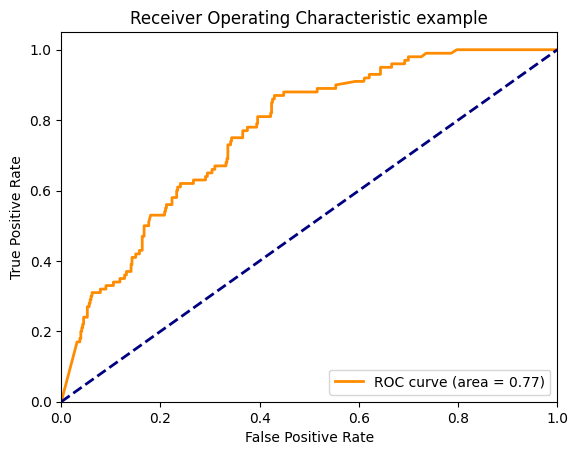

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# probabilities for the positive outcome
y_pred_proba = clf.predict_proba(X_test_selected)[:,1]
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)  # false positive rate and true positive rate
roc_auc = roc_auc_score(y_test, y_pred_proba)

#Save AUC values
df = pd.DataFrame({
    'AUC': roc_auc,
    'FPR': fpr,
    'TPR': tpr
})
df.to_csv('./AUC_Extracts/KC1/KC1_NB_PSO.csv', index=False)

# Plot
plt.figure()
lw = 2  # line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic example')
plt.legend(loc="lower right")
plt.show()